1. 用pytorch实现一个权重衰减实例，通过绘图，对比采用权重衰减前后的训练误差和测试误差。
2. 实现一个dropout实例，通过绘图，观察不同的dropout概率下的train loss, train acc和test acc的变化。

In [1]:
# !usr/bin/python
# -*- encoding: utf-8 -*-
# Project: Weight Decay & Dropout
# Author: Tracy Tao
# Date: 2022/04/10
# 4.5.2 高维线性回归
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1))*0.01, 0.05 # 实际w，b

In [4]:
help(d2l.synthetic_data)

Help on function synthetic_data in module d2l.torch:

synthetic_data(w, b, num_examples)
    Generate y = Xw + b + noise.
    
    Defined in :numref:`sec_linear_scratch`



In [5]:
train_data = d2l.synthetic_data(true_w, true_b, n_train) # 通过w,b真实值，生成训练集数据量的人造数据集
test_data = d2l.synthetic_data(true_w, true_b, n_test) # 通过w,b真实值，生成测试集数据量的人造数据集

In [6]:
help(d2l.load_array)

Help on function load_array in module d2l.torch:

load_array(data_arrays, batch_size, is_train=True)
    Construct a PyTorch data iterator.
    
    Defined in :numref:`sec_linear_concise`



In [7]:
train_iter = d2l.load_array(train_data, batch_size) # 训练集迭代器
test_iter = d2l.load_array(test_data, batch_size, is_train=False) # 测试集迭代器

In [9]:
def init_params():
    '''定义随机初始化模型参数'''
    w = torch.normal(0,1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w,b]

In [10]:
def l2_penalty(w):
    '''L2 惩罚： ||W||^2 '''
    return torch.sum(w.pow(2))/2

In [11]:
def train(lambd):
    w, b = init_params() # 获得初始化参数
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss # 定义线性回归模型，定义平方损失函数
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l2_penalty(w) 
            # + L2范数惩罚项，lambd是超参数
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l.sum().backward() # 总损失反向传播
            d2l.sgd([w, b], lr, batch_size) # 随机梯度下降优化器，更新w，b
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

- torch.norm(input, p='fro', dim=None, keepdim=False, out=None, dtype=None) 求范数函数

w的L2范数是： 12.708578109741211


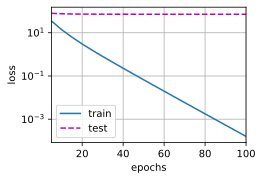

In [12]:
# lambd = 0禁用权重衰减
train(lambd=0)

w的L2范数是： 3.893631935119629


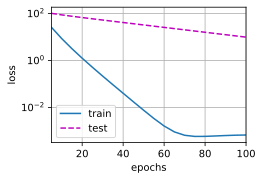

In [13]:
train(lambd=1)

w的L2范数是： 1.2348415851593018


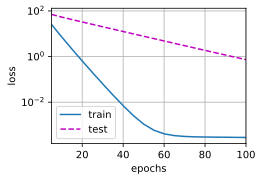

In [14]:
train(lambd=2)

w的L2范数是： 0.3605116009712219


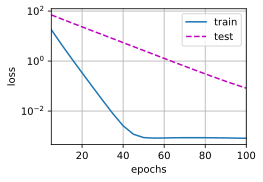

In [15]:
train(lambd=3)

w的L2范数是： 0.12022645771503448


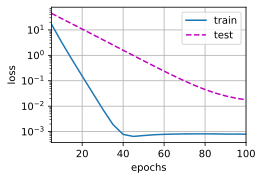

In [16]:
train(lambd=4)

w的L2范数是： 0.06109237298369408


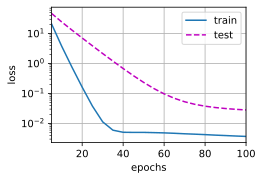

In [17]:
train(lambd=5)

w的L2范数是： 0.03281421959400177


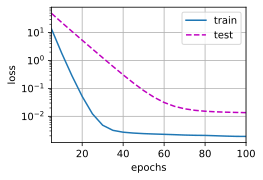

In [18]:
train(lambd=6)

- lambd越大，损失下降所需的epoch越少即训练集下降越快，测试集损失下降越显著，改善了过拟合问题。

In [26]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1)) # 使用Sequential来定义模型
    for param in net.parameters():
        # 模型参数初始化
        param.data.normal_() 
    loss = nn.MSELoss(reduction='none') # 定义均方损失
    num_epochs, lr = 100, 0.003 # 设置epoch和学习率
    trainer = torch.optim.SGD([{'params':net[0].weight, 
                                'weight_decay':wd},
                               {'params':net[0].bias}], 
                              lr=lr) # 随机梯度下降优化器，设置了权重衰减参数
    animator = d2l.Animator(xlabel='epochs',
                            ylabel='loss',
                            yscale='log',
                            xlim=[5, num_epochs],
                            legend = ['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            trainer.zero_grad() # 清除梯度
            l = loss(net(X),y) #计算模型损失
            l.mean().backward() # 计算平均损失，并反向传播
            trainer.step() # 更新参数
        if (epoch +1)%5 ==0:
            animator.add(epoch+1,
                         (d2l.evaluate_loss(net, train_iter,loss),
                          d2l.evaluate_loss(net, test_iter,loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.130640029907227


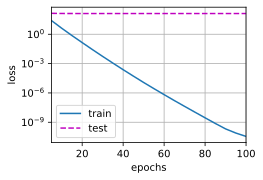

In [27]:
train_concise(0)

w的L2范数： 0.0647599995136261


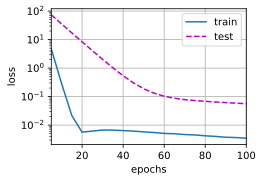

In [28]:
train_concise(6)

- num_epoch =100 , learning_rate =0.003, 设置权重衰减Lambda =6, 训练集和测试集损失显著下降，L2范数显著减小，减轻了过拟合问题。

In [32]:
def dropout_layer(X,dropout):
    '''设置丢弃层，设定丢弃率范围，如果不满足直接raise assertError'''
    assert 0 <+ dropout <=1
    if dropout == 1: # 如果丢弃率为1,则全部丢弃，清除输入值
        return torch.zeros_like(X)
    if dropout == 0: # 如果丢弃率为0，则全部保留，直接将X作为下一层的输入值
        return X
    mask = (torch.rand(X.shape) > dropout).float() 
    return mask * X /(1.0 - dropout)

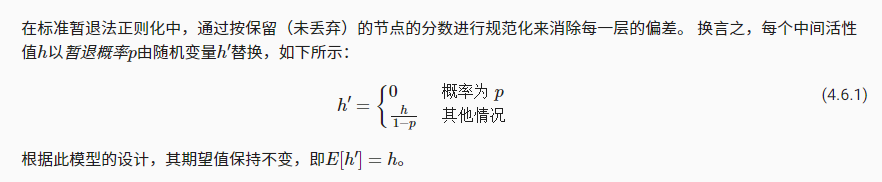
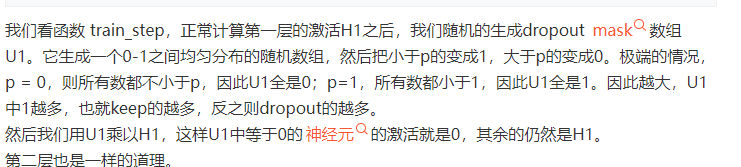

- Python assert（断言）用于判断一个表达式，在表达式条件为 false 的时候触发异常
    - assert expression [, arguments]

In [30]:
X = torch.arange(16, dtype=torch.float32).reshape((2,8))
X

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [33]:
dropout_layer(X, 0.5)

tensor([[ 0.,  0.,  0.,  6.,  0.,  0., 12., 14.],
        [16.,  0.,  0., 22.,  0., 26.,  0.,  0.]])

In [34]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10,256,256

In [35]:
dropout1, dropout2 = 0.2, 0.5

In [36]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training = True):
        super(Net, self).__init__() # 继承父类的Net即上一层
        self.num_inputs = num_inputs 
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        '''feed forward'''
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs)))) # 隐藏层一的输出
        if self.training == True: 
            # 只有在训练模型时才使用dropout
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1)) # H1作为输入，计算隐藏层二的输出
        if self.training == True:
            # 只有在训练模型时才使用dropout
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2) # H2作为输出层的输入，计算输出
        return out

In [37]:
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)
net #定义模型

Net(
  (lin1): Linear(in_features=784, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)

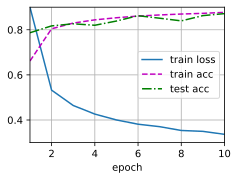

In [38]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [39]:
dropout1, dropout2 = 0.2, 0.5
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

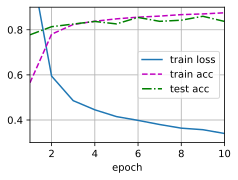

In [27]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

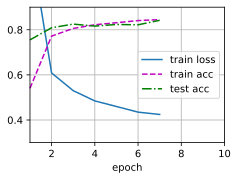

In [ ]:
dropout1, dropout2 = 0.5, 0.4
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

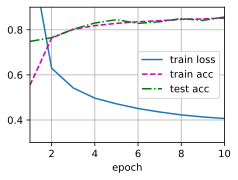

In [30]:
dropout1, dropout2 = 0.6, 0.3
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

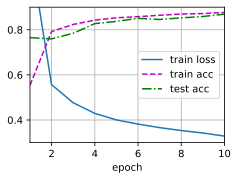

In [31]:
dropout1, dropout2 = 0.2, 0.2
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

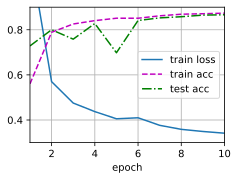

In [32]:
dropout1, dropout2 = 0.2, 0.4
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

- 定义两个暂退层，增大总体dropout，虽然train_loss减少，train_acc和test_acc变接近；减小总体dropout，train_acc和test_acc均增大。
    - 但是，感觉改变dropout1 和 dropout2，在训练过程中train_acc和test_acc变化趋势是随机的，训练结果train_acc 和 test_acc是确定的、显著变化。